# BavarianCrops

In [1]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn
import matplotlib.pyplot as plt


from earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np

import datetime
import seaborn

data_root = "../elects_data"
device = "cuda" if torch.cuda.is_available() else "cpu"

sequencelength=150


/home/marc/anaconda3/envs/elects/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Download model snapshots

In [2]:

!wget -nc "https://elects.s3.eu-central-1.amazonaws.com/elects_models.zip"
!unzip -n "elects_models.zip"

!wget -nc "https://elects.s3.eu-central-1.amazonaws.com/bavariancropsruns_epsilon.zip"
!unzip -n "bavariancropsruns_epsilon.zip"


File ‘elects_models.zip’ already there; not retrieving.

Archive:  elects_models.zip
File ‘bavariancropsruns_epsilon.zip’ already there; not retrieving.

Archive:  bavariancropsruns_epsilon.zip


In [3]:
test_ds = BavarianCrops(root=data_root,partition="eval", sequencelength=sequencelength, return_ids=True)

nclasses = 7
input_dim = 13
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
model.load_state_dict(torch.load("bavariancrops.pth"))
model.eval()

EarlyRNN(
  (intransforms): Sequential(
    (0): LayerNorm((13,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=13, out_features=64, bias=True)
  )
  (backbone): LSTM(64, 64, num_layers=2, bias=False, batch_first=True, dropout=0.2)
  (classification_head): ClassificationHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=7, bias=True)
      (1): LogSoftmax(dim=2)
    )
  )
  (stopping_decision_head): DecisionHead(
    (projection): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

## Load Day of Year per Field

In [15]:
npydoy_url = "https://elects.s3.eu-central-1.amazonaws.com/bavariancropsdoys.npy"
npydoy = 'bavariancropsdoys.npy'

if not os.path.exists(npydoy):
    !wget $npydoy_url
    
doys_dict = np.load(npydoy, allow_pickle=True).flat[0]


## Test Functions

In [35]:

def test(snapshot_path):
    """
    loads snapshot of model weights and tests it on dataset
    """

    with torch.no_grad():

        nclasses = 7
        input_dim = 13
        model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
        model.load_state_dict(torch.load(snapshot_path))
        model.eval()

        dataloader = DataLoader(test_ds, batch_size=256)
        model.eval()

        stats = []
        losses = []
        slengths = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            

            log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
            
            slengths.append(seqlengths.cpu().detach())
            
            stat = {}
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            #print(y_true.cpu().detach().numpy().shape)
            #print(ids.shape)
            stat["ids"] = ids.unsqueeze(1)
            #stat["seqlengths"] = seqlengths.cpu().detach().numpy()

            stats.append(stat)


        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = Ts = torch.cat(slengths).numpy()

        return stats

def test_print(snapshot_path):
    stats = test(snapshot_path)
    y_pred = stats["predictions_at_t_stop"][:,0]
    y_true = stats["targets"][:,0]

    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    Ts = stats["seqlengths"]

    T = sequencelength
    t_stop = stats["t_stop"][:,0]

    earliness = 1-(t_stop / Ts)
    t_stop_mean = earliness.mean()
    t_stop_std = earliness.std()

    print(f"{accuracy:.2f} & {kappa:.2f} & {earliness.mean():.2f} $\\pm$ {earliness.std():.2f}")
        #return slengths

In [36]:
stats = test("bavariancrops.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

In [40]:

doy_stop = []
for id, t_stop in zip(stats["ids"][:,0], stats["t_stop"][:,0]):
    doys = doys_dict[id]
    doy_stop.append(doys[t_stop-3])
doy_stop = np.array(doy_stop)

In [41]:
test_print("bavariancrops.pth")

  0%|          | 0/31 [00:00<?, ?it/s]

0.86 & 0.77 & 0.57 $\pm$ 0.18


## Distribution of Stopping Times

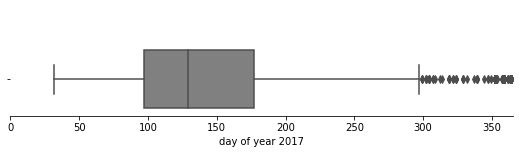

In [42]:

fig, ax = plt.subplots(figsize=(9,2))
seaborn.boxplot(x=doy_stop,orient="h",ax=ax, color="gray")
seaborn.despine(offset=0.5, left=True)
ax.set_xlabel("day of year 2017")
ax.set_ylabel("")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
#ax.set_xticklabels(dates, rotation=20, ha='right')
fig.savefig("/tmp/violin.pdf",dpi=300,bbox_inches='tight')

## Stopping Times per Class

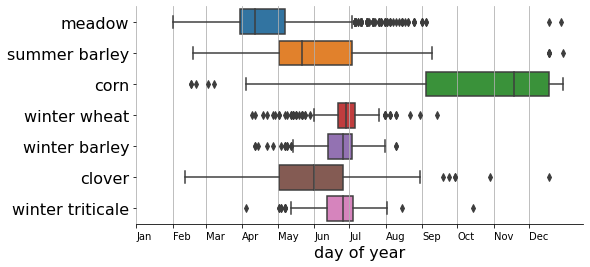

In [43]:


doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


labels_names = ["meadow", "summer barley", "corn", "winter wheat", "winter barley", "clover", "winter triticale"]

fig, ax = plt.subplots(figsize=(8,4))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax)
ax.set_yticklabels(labels_names, fontsize=16)
ax.set_xlabel("day of year", fontsize=16)
ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")
seaborn.despine(left=True)
fig.savefig("/home/marc/projects/re-elects/images/phenology/bavariancrops.pdf", transparent=True, bbox_inches="tight")

## Stopping times per correct/false

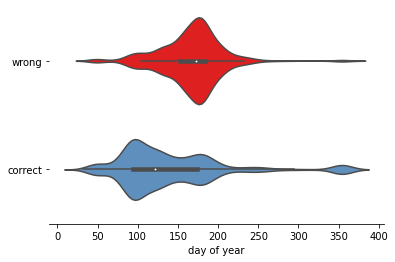

In [44]:
canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"

correct = stats["predictions_at_t_stop"][:,0] == stats["targets"][:,0]

fig, ax = plt.subplots(figsize=(6,4))
seaborn.violinplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["wrong", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhviolin.pdf")

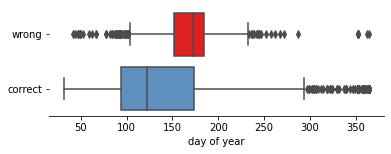

In [45]:
fig, ax = plt.subplots(figsize=(6,2))
seaborn.boxplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["wrong", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhboxplotbavariancrops.pdf", bbox_inches="tight")

## KS-Test of Stopping times are separate

In [46]:
mean_correct = doy_stop[correct].mean()
mean_wrong = doy_stop[~correct].mean()
std_correct = doy_stop[correct].std()
std_wrong = doy_stop[~correct].std()

Ts = stats["seqlengths"]
t_stop = stats["t_stop"][:,0]
earliness = 1-(t_stop / Ts)

from scipy import stats as st
print(st.ks_2samp(doy_stop[correct], doy_stop[~correct]))

print(f"correct {mean_correct} +- {std_correct}")
print(f"correct {mean_wrong} +- {std_wrong}")

KstestResult(statistic=0.4121244769196476, pvalue=7.001825497011288e-150)
correct 140.47183942480527 +- 68.16869220570341
correct 165.68073878627968 +- 39.043884249078324


<AxesSubplot:>

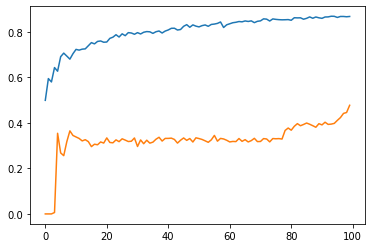

In [50]:
import pandas as pd
df = pd.read_csv("bavariancropsr1e10.pth.csv")
df.accuracy.plot()
df.earliness.plot()

<AxesSubplot:>

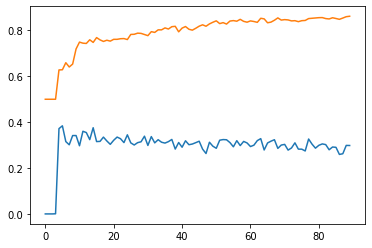

In [51]:
import pandas as pd
df = pd.read_csv("bavariancropsr1e0.pth.csv")
df.earliness.plot()

df.accuracy.plot()

/tmp/epsilonexp/kappa_bavariancropsr1e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr2e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr3e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr4e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr5e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr6e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr7e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr8e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr9e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr10e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr11e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr12e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr13e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr14e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr15e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr16e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr17e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr18e0.pdf
/tmp/epsilonexp/kappa_bavariancropsr19e0.pdf


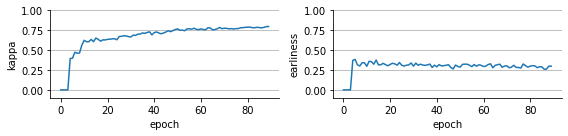

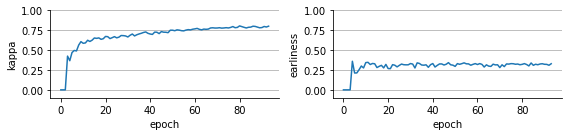

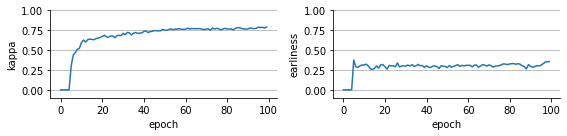

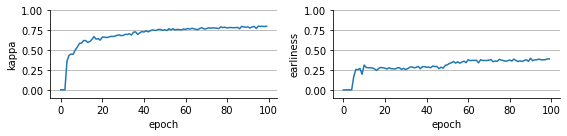

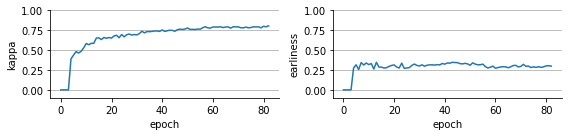

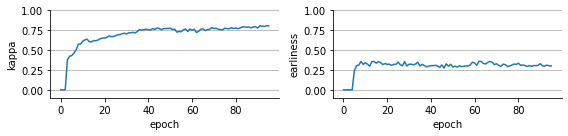

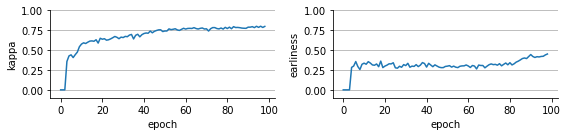

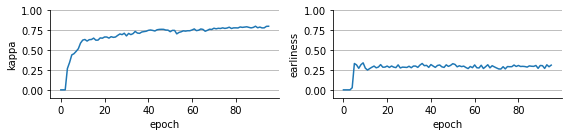

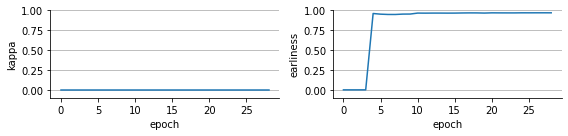

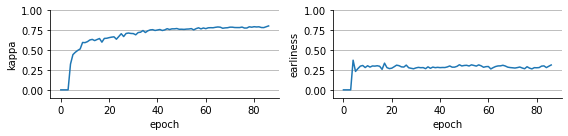

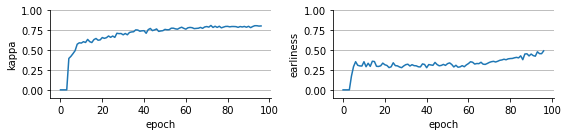

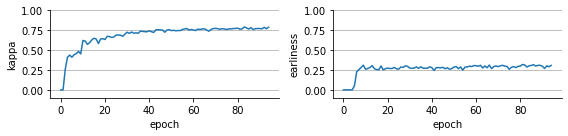

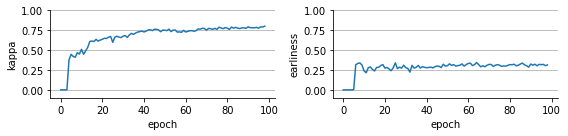

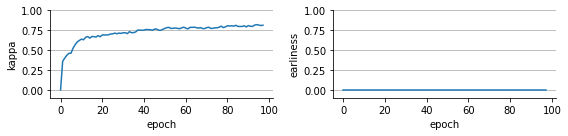

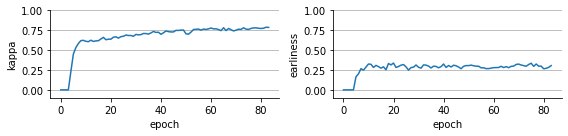

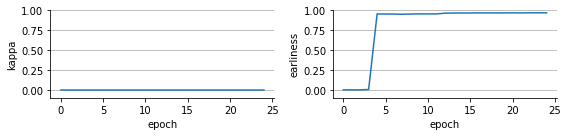

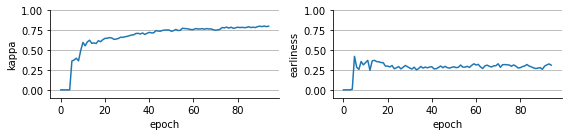

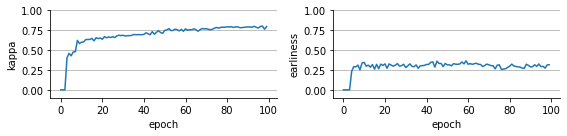

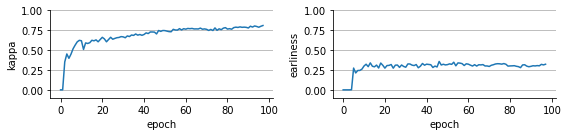

In [52]:
import pandas as pd

storepath = "/tmp/epsilonexp"
os.makedirs(storepath,exist_ok=True)

def plot_curves(csvpath, kappa=True):
    fig, axs = plt.subplots(1,2, figsize=(8,2))
    df = pd.read_csv(csvpath)
    
    ax=axs[0]
    if kappa:
        df.kappa.plot(ax=ax)
        ax.set_ylabel("kappa")
    else:
        df.accuracy.plot(ax=ax)
        ax.set_ylabel("accuracy")
    
    ax.set_xlabel("epoch")
    ax.set_ylim(-.1,1)
    ax.grid(True,axis="y")
    ax.set_yticks([0,0.25,0.5,0.75,1])
    
    ax=axs[1]
    df.earliness.plot(ax=ax)
    ax.set_ylim(-.1,1)
    ax.grid(True,axis="y")
    ax.set_xlabel("epoch")
    ax.set_ylabel("earliness")
    ax.set_ylim(-.1,1)
    ax.grid(True,axis="y")
    ax.set_yticks([0,0.25,0.5,0.75,1])
    
    seaborn.despine()
    fig.tight_layout()
    
    basename = os.path.basename(csvpath)
    if kappa:
        basename = "kappa_"+basename
    pdfpath = basename.replace(".pth.csv",".pdf")
    savepath = os.path.join(storepath,pdfpath)
    fig.savefig(savepath,bbox_inches="tight",transparent=True)
    print(savepath)
    row = df.iloc[-1]
    row.name = f"run{r}"
    runs.append(row)
    return row

runs = []
for r in range(1,20):
    row = plot_curves(f"bavariancropsr{r}e0.pth.csv")
e0 = pd.DataFrame(runs)

/tmp/epsilonexp/kappa_bavariancropsr1e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr2e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr3e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr4e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr5e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr6e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr7e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr8e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr9e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr10e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr11e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr12e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr13e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr14e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr15e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr16e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr17e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr18e10.pdf
/tmp/epsilonexp/kappa_bavariancropsr19e10.pdf


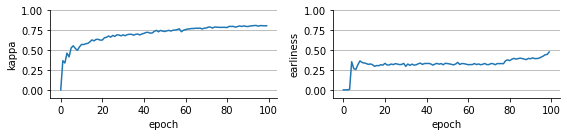

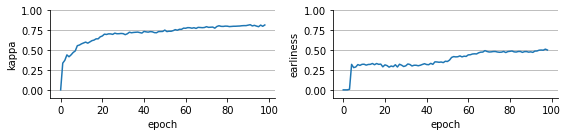

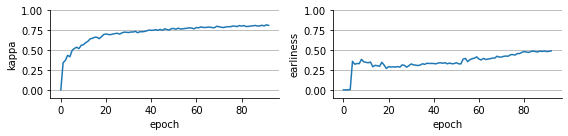

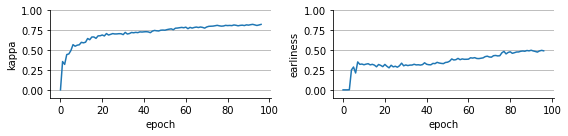

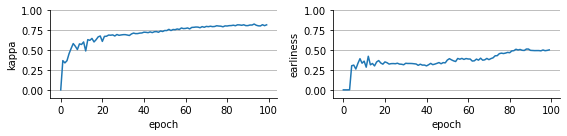

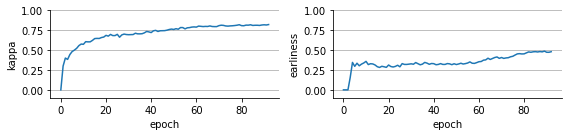

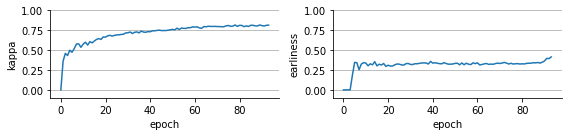

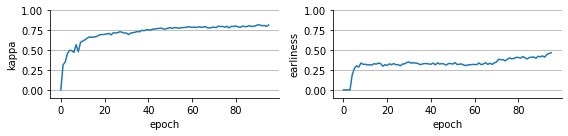

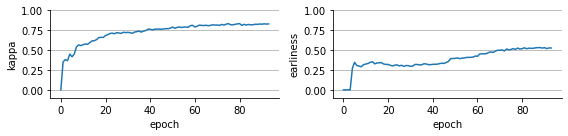

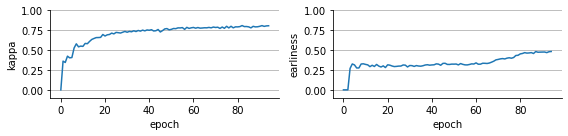

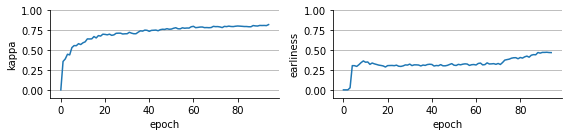

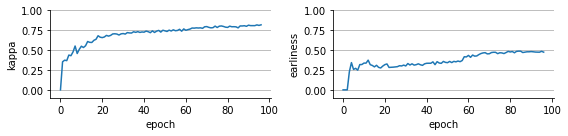

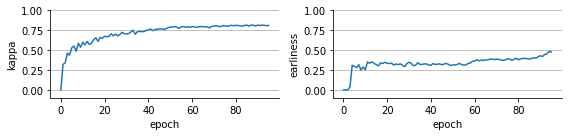

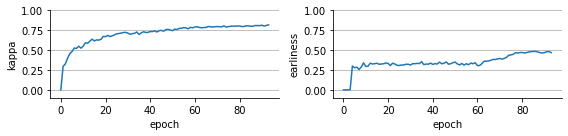

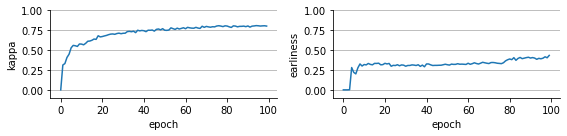

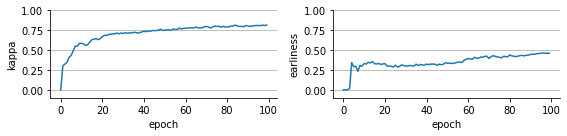

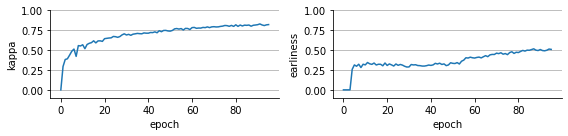

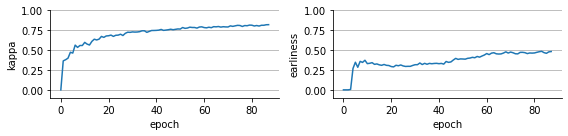

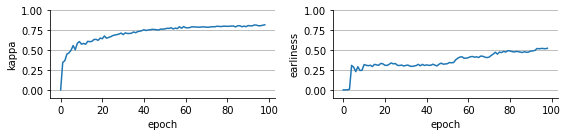

In [53]:
runs = []
for r in range(1,20):
    row = plot_curves(f"bavariancropsr{r}e10.pth.csv")
e10 = pd.DataFrame(runs)